<a href="https://colab.research.google.com/github/DhruvaBansal00/ConfidentMT/blob/master/driver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!ls
%cd drive/My Drive/ConfidentMachineTranslation/flores
!ls
!pwd
import sys
sys.path.append('/content/drive/My Drive/ConfidentMachineTranslation/flores/src/')

drive  sample_data
/content/drive/My Drive/ConfidentMachineTranslation/flores
analysis			      FeatureSubsetBinaryClassifers.ipynb
Analysis			      FLORES.ipynb
backward_models			      LanguageAnalysis.ipynb
BoostedBinaryClassifers.ipynb	      language_models
checkpoints			      LM_Thresholding.ipynb
ClassificationDataset		      NCD_Analysis.ipynb
CompareBaselineWithClassifiers.ipynb  NNClassification.ipynb
configs				      noisychannel
data				      NoisyChannel.ipynb
data-bin			      Resources
driver.ipynb			      scripts
Ensembles			      src
Ensembling
/content/drive/My Drive/ConfidentMachineTranslation/flores


In [3]:
pip install fairseq sacrebleu sentencepiece fastBPE sacremoses xgboost

In [0]:
##Methods for CLI with fairseq - WIP

class FairseqWrapper:

    def runFairseqGenerate(self, dataFolder, sourceLang, targetLang, fwModel, beam, lenpen, dataSet, removeBpe, saveFile):
        !fairseq-generate $dataFolder --source-lang $sourceLang --target-lang $targetLang \
        --path $fwModel --beam $beam --lenpen $lenpen --gen-subset $dataSet --remove-bpe=$removeBpe --sacrebleu > $saveFile

    def runFairseqScore(self, translations, groundTruth, saveFile, metric):
        !fairseq-score --sys $translations --ref $groundTruth --$metric > $saveFile
    
    def runFairseqPreprocess(self, srcdict, preprocCommand, bpeTranslations, dest):
        !fairseq-preprocess --only-source --srcdict $srcdict --$preprocCommand $bpeTranslations \
        --destdir $dest --workers 20

    def runFairseqEvalLM(self, preprocFile, lmModel, batchSize, maxTokens, dataSet, saveFile):
        !fairseq-eval-lm $preprocFile --path $lmModel --batch-size $batchSize --max-tokens $maxTokens \
        --output-word-probs --sample-break-mode eos --gen-subset $dataSet > $saveFile

In [0]:
dataFolder = "data-bin/wiki_ne_en_bpe5000/"
fwModel = "Ensembles/April_04.pt"
bwModel = "backward_models/April_17.pt"
lmModel = "language_models/lm/checkpoint_best.pt"
sourceLang = "ne"
targetLang = "en"


In [7]:
import translationUtils
from translation import Translation

trainTranslations = translationUtils.getTranslationFromDataset("valid", fwModel, bwModel, lmModel, "ne", "en", FairseqWrapper(), dataFolder, False, True)
testTranslations = translationUtils.getTranslationFromDataset("test", fwModel, bwModel, lmModel, "ne", "en", FairseqWrapper(), dataFolder, False, True)

  0% 0/12 [00:00<?, ?it/s]/pytorch/aten/src/ATen/native/BinaryOps.cpp:66: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.
  0% 0/13 [00:00<?, ?it/s]/pytorch/aten/src/ATen/native/BinaryOps.cpp:66: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.
Namespace(align_suffix=None, alignfile=None, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='analysis/preprocessed_translations', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=1000, lr_scheduler='fixed', memory_efficient_fp16=False, min_loss_scale=0.0001, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_so

In [18]:
import dataUtils
import classification
import thresholding
import numpy as np
from tqdm.notebook import tqdm

trainTranslations = dataUtils.createObjectsFromFile("valid")
testTranslations = dataUtils.createObjectsFromFile("test")

averageLogprobThresholding = thresholding.precisionCurveFromThresholding(testTranslations, np.linspace(-1.5, 0, 25).tolist(), 0, FairseqWrapper())
oracleThresholding = thresholding.precisionCurveFromThresholding(testTranslations, np.linspace(0, 60, 25).tolist(), 4, FairseqWrapper())

comparisonPoints = []
featureSubsets = [[0], #just baseline Forward Model score [P(T|S)]
                  [0, 11, 12], #Similar to noisy channel decoding: P(y|x), p(x|y), p(y) 
                  [0, 11, 12, 19, 20], #Like above + sentence length features
                  [0, 11, 12, 16, 17, 18], #Like above + ngram features
                  [0, 5, 6, 11, 12, 19, 20], #Like above + sentence length features + Rare words
                  [0, 11, 12, 13, 14, 19, 20], #Like above + sentence length features + end of sentence identifiers
                  [0, 5, 6, 11, 12, 16, 17, 18], #Like above + ngram features + Rare words
                  [0, 11, 12, 13, 14, 16, 17, 18], #Like above + ngram features + end of sentence identifiers
                  [0, 5, 6, 11, 12, 13, 14, 19, 20], #Like above + sentence length features + Rare words + end of sentence identifiers
                  [0, 5, 6, 11, 12, 13, 14, 16, 17, 18] #Like above + ngram features + Rare words + end of sentence identifiers
                  ]
for subset in featureSubsets:
    currPoints = classification.precisionCurveFromClassification(trainTranslations, testTranslations, "LogisticRegression", FairseqWrapper(), [10], subset)
    comparisonPoints.append((currPoints[0][0], currPoints[1][0]))


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


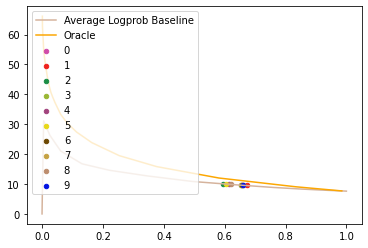

In [27]:
import matplotlib.pyplot as plt
import random 

plt.plot(averageLogprobThresholding[0], averageLogprobThresholding[1], label = "Average Logprob Baseline", color=(random.random(), random.random(), random.random()))
plt.plot(oracleThresholding[0], oracleThresholding[1], label = "Oracle", color=(random.random(), random.random(), random.random()))

for index, point in enumerate(comparisonPoints):
    plt.scatter([point[0]], [point[1]], label = str(index), color=(random.random(), random.random(), random.random()), s=20)

plt.legend(loc="upper left")
plt.savefig("pointWiseComparison10.png")
plt.show()


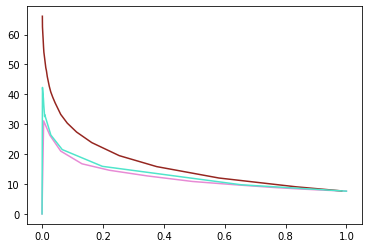

In [28]:
ncdClassifier = classification.precisionCurveFromClassification(trainTranslations, testTranslations, "LogisticRegression", FairseqWrapper(), np.linspace(0.1, 60, 25).tolist(), [0, 11, 12])

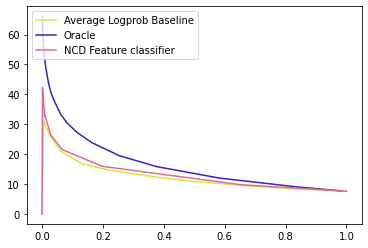

In [29]:
plt.plot(averageLogprobThresholding[0], averageLogprobThresholding[1], label = "Average Logprob Baseline", color=(random.random(), random.random(), random.random()))
plt.plot(oracleThresholding[0], oracleThresholding[1], label = "Oracle", color=(random.random(), random.random(), random.random()))
plt.plot(ncdClassifier[0], ncdClassifier[1], label = "NCD Feature classifier", color=(random.random(), random.random(), random.random()))

plt.legend(loc="upper left")
plt.savefig("classifierComparison.png")
plt.show()
